# Project

...

## Details

...

## Implementation

...

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
from scipy.stats import friedmanchisquare
from sklearn.metrics import roc_curve, auc
plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.rcParams['font.size'] = 14

In [3]:
def i_m_test(x_i_j):
    T_i = stats.rankdata(x_i_j, axis=0)-1
    T_v = np.sum(T_i, axis=1)
    
    N = x_i_j.shape[1]
    k = T_i.shape[0]
    
    mu = N*(k-1) / 2
    var = N*(k**2 -1) / 12
    
    T = np.sum((T_v - mu)**2 / var)
    
    return stats.chi2(df=k-1).sf(T)

## Comparison (Friedman)

...

In [4]:
def get_friedman(X_ij):
    b, k = np.shape(X_ij)
    
    R_ij = stats.rankdata(X_ij,axis=-1)
    R_j = np.sum(R_ij,axis=0)
    
    T1 = (12/(b*k*(k+1)))*np.sum((R_j-0.5*b*(k+1))**2)
    p = stats.chi2(df=k-1).sf(T1)
    
    return p

## Example Comparison

...

In [5]:
x_i_j = np.array([
    np.array([ 14.97,   5.80,  25.03,   5.50 ]),
    np.array([  5.83,  13.96,  21.96,   55.51 ]),
    np.array([ 17.89,  23.03,  61.09,   18.62 ])
])

In [6]:
friedmanchisquare(*x_i_j)

FriedmanchisquareResult(statistic=3.5, pvalue=0.1737739434504451)

In [7]:
i_m_test(x_i_j)

0.07243975703425146

## Experiments

...

In [8]:
def run_experiment(
    effect_size, x_i_j_k, title,
    n_trials=1000, alpha=0.05, alt='norm'
):
    ks_power = []
    im_power = []

    all_ks_pvals_null = []
    all_im_pvals_null = []
    all_ks_pvals_alt = []
    all_im_pvals_alt = []

    for e in effect_size:
        ks_rejects = 0
        im_rejects = 0

        ks_pvals_null = []
        im_pvals_null = []
        ks_pvals_alt = []
        im_pvals_alt = []

        for _ in range(n_trials):
            x_1_null = stats.norm(0, 1).rvs(4)  # null
            x_2_null = stats.norm(0, 1).rvs(4)
            x_3_null = stats.norm(0, 1).rvs(4)
            x_null = np.array([x_1_null, x_2_null, x_3_null])

            ks_pvals_null.append(get_friedman(x_null.T))
            im_pvals_null.append(i_m_test(x_null))

            if alt == 'norm':
                x_1_alt = stats.norm(e, 1).rvs(4)  # alt
            elif alt == 'laplace':
                x_1_alt = stats.laplace(e, 1).rvs(4)
            elif alt == 'cauchy':
                x_1_alt = stats.cauchy(e, 1).rvs(4)
            else:
                print("Not supported.")
                return None
            x_2_alt = stats.norm(0, 1).rvs(4)
            x_3_alt = stats.norm(0, 1).rvs(4)
            x_alt = np.array([x_1_alt, x_2_alt, x_3_alt])

            ks_p = get_friedman(x_alt.T)
            im_p = i_m_test(x_alt)

            ks_pvals_alt.append(ks_p)
            im_pvals_alt.append(im_p)

            if ks_p < alpha:
                ks_rejects += 1
            if im_p < alpha:
                im_rejects += 1

        ks_power.append(ks_rejects / n_trials)
        im_power.append(im_rejects / n_trials)

        all_ks_pvals_null.extend(ks_pvals_null)
        all_im_pvals_null.extend(im_pvals_null)
        all_ks_pvals_alt.extend(ks_pvals_alt)
        all_im_pvals_alt.extend(im_pvals_alt)

    plt.figure(figsize=(8, 4))
    plt.plot(effect_size, ks_power, label='Freidman Test')
    plt.plot(effect_size, im_power, label='IM Test')
    plt.xlabel("Effect Size")
    plt.ylabel("Power")
    plt.title(f'{title} | Power Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    labels = np.array([0]*len(all_ks_pvals_null) + [1]*len(all_ks_pvals_alt))

    scores_ks = 1 - np.array(all_ks_pvals_null + all_ks_pvals_alt)
    fpr_ks, tpr_ks, _ = roc_curve(labels, scores_ks)
    auc_ks = auc(fpr_ks, tpr_ks)

    scores_im = 1 - np.array(all_im_pvals_null + all_im_pvals_alt)
    fpr_im, tpr_im, _ = roc_curve(labels, scores_im)
    auc_im = auc(fpr_im, tpr_im)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr_ks, tpr_ks, label=f"Freidman Test (AUC = {auc_ks:.2f})")
    plt.plot(fpr_im, tpr_im, label=f"IM Test (AUC = {auc_im:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'{title} | ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

### 01 | Normal vs. Normal 

...

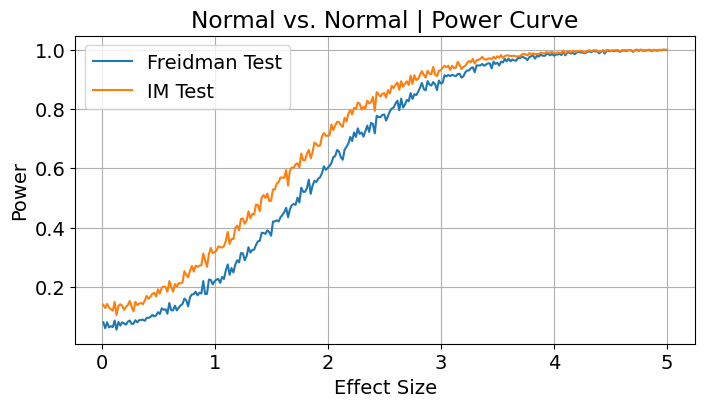

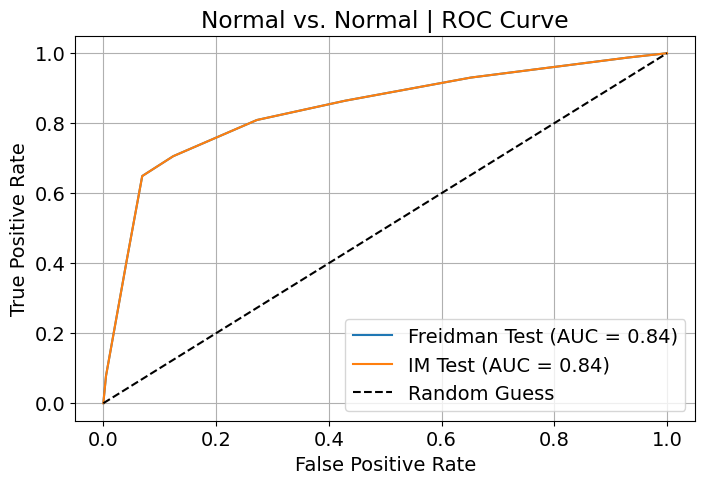

In [15]:
effect_size = np.linspace(0.01, 5.0, 300)
n=4

x_1 = np.array([stats.norm(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Normal vs. Normal')

### 02 | Laplace vs. Normal 

...

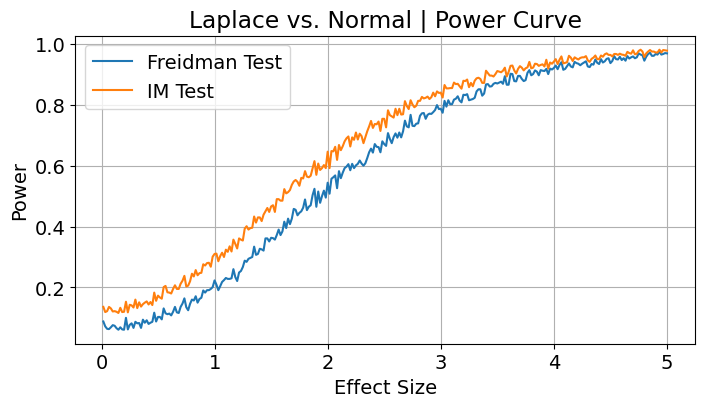

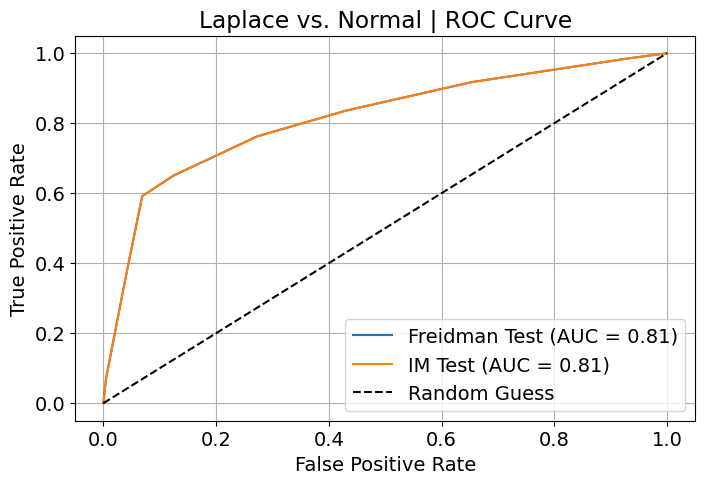

In [16]:
effect_size = np.linspace(0.01, 5.0, 300)
n=4

x_1 = np.array([stats.laplace(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Laplace vs. Normal', alt='laplace')

### 03 | Cauchy vs. Normal 

...

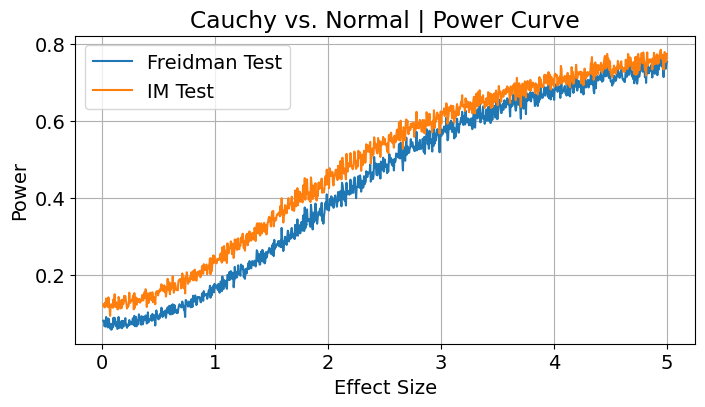

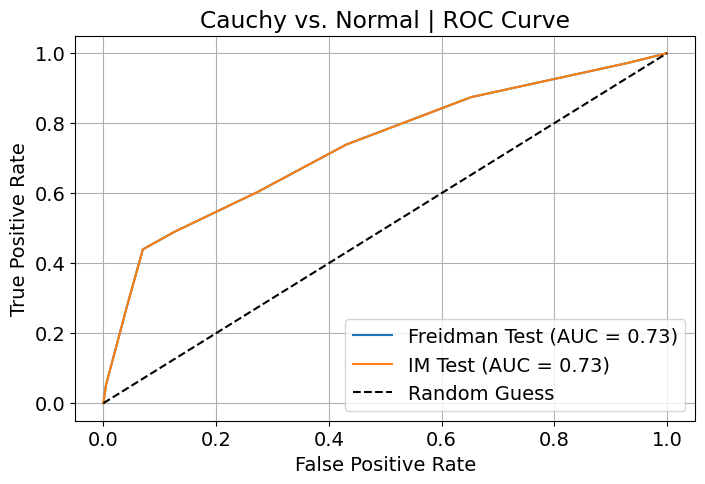

In [17]:
effect_size = np.linspace(0.01, 5.0, 1000)
n=4

x_1 = np.array([stats.cauchy(e, 1).rvs(n) for e in effect_size])
x_2 = stats.norm(0, 1).rvs(effect_size.shape+(n,))
x_3 = stats.norm(0, 1).rvs(effect_size.shape+(n,))

x_i_j_k = np.array([x_1, x_2, x_3])

run_experiment(effect_size, x_i_j_k, 'Cauchy vs. Normal', alt='cauchy')

### 04 | Higher Variance

...

In [ ]:
def run_experiment_variance(
    effect_size, x_i_j_k, title,
    n_trials=1000, alpha=0.05, alt='norm'
):
    ks_power = []
    im_power = []

    all_ks_pvals_null = []
    all_im_pvals_null = []
    all_ks_pvals_alt = []
    all_im_pvals_alt = []

    for e in effect_size:
        ks_rejects = 0
        im_rejects = 0

        ks_pvals_null = []
        im_pvals_null = []
        ks_pvals_alt = []
        im_pvals_alt = []

        for _ in range(n_trials):
            x_1_null = stats.norm(0, 1).rvs(100)  # null
            x_2_null = stats.norm(0, 1).rvs(100)
            x_3_null = stats.norm(0, 1).rvs(100)
            x_null = np.array([x_1_null, x_2_null, x_3_null])

            ks_pvals_null.append(kruskal_wallis(x_null))
            im_pvals_null.append(i_m_test(x_null))

            if alt == 'norm':
                x_1_alt = stats.norm(0, e).rvs(100)  # alt
            elif alt == 'laplace':
                x_1_alt = stats.laplace(0, e).rvs(100)
            elif alt == 'cauchy':
                x_1_alt = stats.cauchy(0, e).rvs(100)
            else:
                print("Not supported.")
                return None
            x_2_alt = stats.norm(0, 1).rvs(100)
            x_3_alt = stats.norm(0, 1).rvs(100)
            x_alt = np.array([x_1_alt, x_2_alt, x_3_alt])

            ks_p = kruskal_wallis(x_alt)
            im_p = i_m_test(x_alt)

            ks_pvals_alt.append(ks_p)
            im_pvals_alt.append(im_p)

            if ks_p < alpha:
                ks_rejects += 1
            if im_p < alpha:
                im_rejects += 1

        ks_power.append(ks_rejects / n_trials)
        im_power.append(im_rejects / n_trials)

        all_ks_pvals_null.extend(ks_pvals_null)
        all_im_pvals_null.extend(im_pvals_null)
        all_ks_pvals_alt.extend(ks_pvals_alt)
        all_im_pvals_alt.extend(im_pvals_alt)

    plt.figure(figsize=(8, 4))
    plt.plot(effect_size, ks_power, label='Kruskal-Wallis')
    plt.plot(effect_size, im_power, label='IM Test')
    plt.xlabel("Effect Size")
    plt.ylabel("Power")
    plt.title(f'{title} | Power Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    labels = np.array([0]*len(all_ks_pvals_null) + [1]*len(all_ks_pvals_alt))

    scores_ks = 1 - np.array(all_ks_pvals_null + all_ks_pvals_alt)
    fpr_ks, tpr_ks, _ = roc_curve(labels, scores_ks)
    auc_ks = auc(fpr_ks, tpr_ks)

    scores_im = 1 - np.array(all_im_pvals_null + all_im_pvals_alt)
    fpr_im, tpr_im, _ = roc_curve(labels, scores_im)
    auc_im = auc(fpr_im, tpr_im)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr_ks, tpr_ks, label=f"Kruskal-Wallis (AUC = {auc_ks:.2f})")
    plt.plot(fpr_im, tpr_im, label=f"IM Test (AUC = {auc_im:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'{title} | ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

### Real-World Example

...

In [ ]:
x_i_j = np.array([
    [2.1, 2.4, 6.8],
    [1.9, 2.2, 5.1],
    [2.0, 2.1, 3.0],
    [2.2, 2.5, 10.8],
    [2.0, 2.3, 4.5]
])

In [ ]:
print(f'Friedman: {get_friedman(x_i_j.T)}, IM: {i_m_test(x_i_j)}')